In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST3_113.JPG
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_014.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_046.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_045.JPG
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_070.JPG
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_071.JPG
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_097.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST3_084.jpg
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST4_041.JPG
/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset/Leafsmut/BLAST3_154.jpg
/content/drive/MyDri

In [4]:
!pip install split-folders

In [5]:
import torch
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import Adam
from tqdm.auto import tqdm
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
import time
import splitfolders

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
data_path = "/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset"

In [8]:
classes = [dir for dir in os.listdir(data_path)]
print(classes)

['Leafsmut', 'Bacterialblight', 'Brownspot']


In [11]:
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/dataset/rice leaf diseases dataset', output="splitted", seed=1337, ratio=(.8, 0,0.2))

Copying files: 4694 files [02:04, 37.82 files/s] 


In [12]:
test_data_path = './splitted/test'
train_data_path = './splitted/train'
classes = [dir for dir in os.listdir(test_data_path)]

In [13]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset_rn50 = datasets.ImageFolder(root=train_data_path, transform=train_transform_rn50)
test_dataset_rn50 = datasets.ImageFolder(root=test_data_path, transform=test_transform_rn50)

In [15]:
test_data_loader = DataLoader(test_dataset_rn50, batch_size=64, shuffle=True)
train_data_loader = DataLoader(train_dataset_rn50, batch_size=64, shuffle=True)

In [16]:
rn50_model = resnet50(weights=ResNet50_Weights.DEFAULT)
rn50_model.fc = nn.Sequential(nn.Linear(in_features=rn50_model.fc.in_features, out_features=38))
for param in rn50_model.parameters():
    param.requires_grad = False

for param in rn50_model.fc.parameters():
    param.requires_grad = True

rn50_model = rn50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [24]:
def training(model, dataloader, loss_fn, optimizer):
    model.train()
    train_loss = 0
    train_acc = 0
    all_preds = []
    all_labels = []

    for batch, (image, label) in enumerate(dataloader):
        image = image.to(device)
        label = label.to(device)

        label_pred = model(image)

        loss = loss_fn(label_pred, label)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        label_pred_class = torch.argmax(torch.softmax(label_pred, dim=1), dim=1)
        train_acc += (label_pred_class == label).sum().item()/len(label_pred)

        # Collect predictions and labels for metrics calculation
        all_preds.extend(label_pred_class.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    # Calculate average loss and accuracy
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    # Calculate additional metrics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    return train_loss, train_acc, f1, precision, recall

In [18]:
loss_fn = nn.CrossEntropyLoss()
optim_rn50 = Adam(params=rn50_model.parameters(), lr=0.001)

In [22]:
def train_process(model, train_dataloader, optimizer, loss_fn, epochs):

    results = {"train_loss": [], "train_acc": [], "f1_score": [], "precision": [], "recall": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, f1, precision, recall = training(model=model,
                                                                dataloader=train_dataloader,
                                                                loss_fn=loss_fn,
                                                                optimizer=optimizer)
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"F1 Score: {f1:.4f} | "
              f"Precision: {precision:.4f} | "
              f"Recall: {recall:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["f1_score"].append(f1)
        results["precision"].append(precision)
        results["recall"].append(recall)

    # Plotting the results
    plot_metrics(results)

    return results

# Function to plot the training metrics
def plot_metrics(results):
    epochs = range(1, len(results["train_loss"]) + 1)

    fig, ax1 = plt.subplots()

    # Plot Train Loss
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(epochs, results["train_loss"], color='tab:blue', label='Train Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # Instantiate a second y-axis for Accuracy, F1, Precision, and Recall
    ax2.set_ylabel('Accuracy & Metrics', color='tab:green')
    ax2.plot(epochs, results["train_acc"], color='tab:green', label='Train Accuracy')
    ax2.plot(epochs, results["f1_score"], color='tab:red', label='F1 Score')
    ax2.plot(epochs, results["precision"], color='tab:orange', label='Precision')
    ax2.plot(epochs, results["recall"], color='tab:purple', label='Recall')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and legends
    plt.title('Training Metrics')
    fig.tight_layout()  # Adjust layout
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0429 | train_acc: 0.9915 | F1 Score: 0.9915 | Precision: 0.9915 | Recall: 0.9915
Epoch: 2 | train_loss: 0.0485 | train_acc: 0.9897 | F1 Score: 0.9896 | Precision: 0.9896 | Recall: 0.9896
Epoch: 3 | train_loss: 0.0441 | train_acc: 0.9899 | F1 Score: 0.9899 | Precision: 0.9899 | Recall: 0.9899
Epoch: 4 | train_loss: 0.0399 | train_acc: 0.9935 | F1 Score: 0.9936 | Precision: 0.9936 | Recall: 0.9936
Epoch: 5 | train_loss: 0.0434 | train_acc: 0.9915 | F1 Score: 0.9915 | Precision: 0.9915 | Recall: 0.9915
Epoch: 6 | train_loss: 0.0385 | train_acc: 0.9947 | F1 Score: 0.9947 | Precision: 0.9947 | Recall: 0.9947
Epoch: 7 | train_loss: 0.0383 | train_acc: 0.9923 | F1 Score: 0.9923 | Precision: 0.9923 | Recall: 0.9923
Epoch: 8 | train_loss: 0.0363 | train_acc: 0.9928 | F1 Score: 0.9928 | Precision: 0.9928 | Recall: 0.9928
Epoch: 9 | train_loss: 0.0372 | train_acc: 0.9928 | F1 Score: 0.9928 | Precision: 0.9928 | Recall: 0.9928
Epoch: 10 | train_loss: 0.0369 | train_acc: 0.

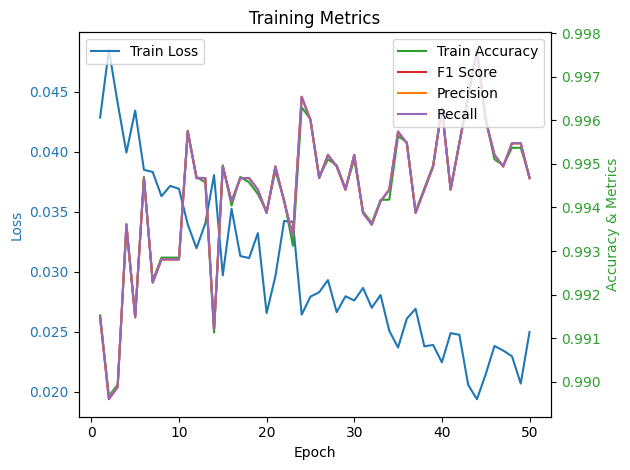

Total Training Time: 1276.829 seconds
Model saved to /content/drive/MyDrive/Colab Notebooks/model/trained_rn50_model.pth


In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

start_time = timer()

rn50_results = train_process(model=rn50_model,train_dataloader=train_data_loader,optimizer=optim_rn50,loss_fn=loss_fn,epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f} seconds")

# Save the model after training
model_save_path = "/content/drive/MyDrive/Colab Notebooks/model/trained_rn50_model.pth"
torch.save(rn50_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [29]:
# Function to compute loss and accuracy during testing, including F1, Precision, and Recall
def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc = 0, 0
    losses = []  # List to store loss values for plotting
    accuracies = []  # List to store accuracy values for plotting
    all_preds = []  # List to store all predictions for calculating metrics
    all_labels = []  # List to store all true labels for calculating metrics

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            val_pred_logits = model(X)
            loss = loss_fn(val_pred_logits, y)
            test_loss += loss.item()
            val_pred_labels = val_pred_logits.argmax(dim=1)
            test_acc += ((val_pred_labels == y).sum().item() / len(val_pred_labels))

            # Store loss and accuracy for plotting
            losses.append(loss.item())
            accuracies.append(((val_pred_labels == y).sum().item() / len(val_pred_labels)))

            # Append predictions and labels to compute metrics later
            all_preds.extend(val_pred_labels.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Compute average loss and accuracy over all batches
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    # Calculate additional metrics
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    # Print performance metrics
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Precision (Weighted): {precision:.4f}")
    print(f"Recall (Weighted): {recall:.4f}")

    # Plotting loss and accuracy
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Batch')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.plot(losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  # Instantiate a second y-axis for accuracy
    ax2.set_ylabel('Accuracy', color='tab:green')
    ax2.plot(accuracies, color='tab:green', label='Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Title and legends
    plt.title('Test Loss and Accuracy per Batch')
    fig.tight_layout()
    plt.show()

    return test_loss, test_acc, f1, precision, recall

Test Loss: 0.0456
Test Accuracy: 0.9865
F1 Score (Weighted): 0.9872
Precision (Weighted): 0.9875
Recall (Weighted): 0.9872


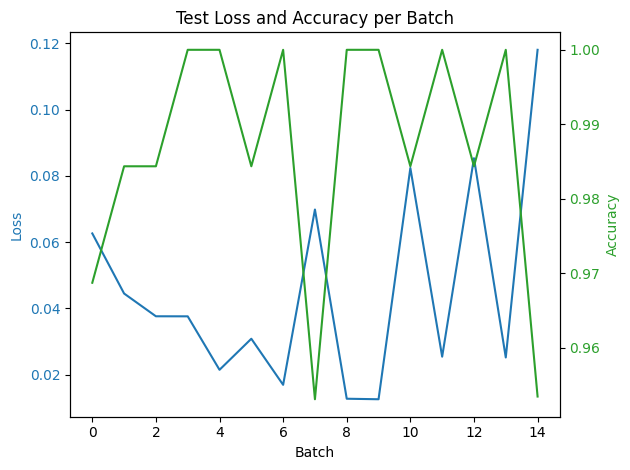

(0.04556399434804916,
 0.9864825581395349,
 0.9872299733451232,
 0.9874681697324752,
 0.987220447284345)

In [30]:
test_step(model=rn50_model, dataloader=test_data_loader, loss_fn=loss_fn)